# Practical session n°5

Notions:
- Semantic segmentation
- Image Denoising
- Fully convolutional networks, U-Net
- Weak supervision (in part II): The noise-to-noise and the Neural Eggs Separation scenarios.

Duration: 1 h 30 + 2 h

In P2, we illustrated how Convolutional Neural Networks (CNNs) are trained for image classification tasks. In this practical session, we demonstrate how to achieve pixel-level predictions for tasks like semantic segmentation and image denoising.

To start, we’ll simply apply an off-the-shelf model. Then, we’ll focus on training a model from scratch (part I, exercise 2 and part II).

In P3, we also introduced a crucial set of methods known as "transfer learning," which is particularly effective when there’s limited training data. In this session, we’ll explore another equally important set of methods called "weak supervision," which is well-suited for cases where ground truth is imperfectly known (Part II).


## Part I: Semantic Segmentation and Image Denoising with Fully Convolutional Networks

This part aims to familiarize you with a semantic segmentation task.

By definition, a Fully Convolutional Network (FCN) does not contain fully connected layers. As a result, the output retains spatial dimensions. This configuration is useful when the learning target itself is an image. This is the case for tasks such as:
- Semantic segmentation, where each pixel is assigned a semantic class (e.g., ground, sky, clouds, buildings, etc.).
- Pixel-wise regression
- Image denoising
- Super-resolution

The first exercise features an FCN built from a ResNet50 for a simple segmentation task defined from a set of real images segmented by hand.

The second exercise proposes a pixel-wise regression task, completely supervised, defined on a set of dynamically generated synthetic images.

### **Exercise 1: Semantic Segmentation with FCN-ResNet (no training)**

**A.** Presentation of the Dataset

In the following cells, we load the necessary libraries, download the set of segmented images prepared for the [Pascal VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/segexamples/index.html) challenge, and visualize input-target pairs from the training set:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

In [2]:
# Check GPU availability

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [3]:
# Load the training dataset

input_resize = transforms.Resize((128, 128))
target_resize = transforms.Resize((128, 128))

train_dataset_viz = datasets.VOCSegmentation(
    './data',
    year='2007',
    image_set='train',
    download = True,
    transform=input_resize,
    target_transform=target_resize,
)

100%|██████████| 4.52k/4.52k [00:00<00:00, 10.8MB/s]


RuntimeError: File not found or corrupted.

In [ ]:
# Viz some images

import math

def plot_images(images, num_per_row=4, title=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row,figsize=(4*num_per_row,4*num_rows))
    #fig.subplots_adjust(wspace=0, hspace=0)

    for image, ax in zip(images, axes.flat):
        ax.imshow(image)
        ax.axis('off')

    return fig

# Echantilonnage du dataset de viz:

inputs, ground_truths = list(zip(*[train_dataset_viz[i] for i in range(8)]))

_ = plot_images(inputs)

In [ ]:
# Viz some targets

_ = plot_images(ground_truths)

**Question 1:** How many classes are there? \\
Search the web for the difference between semantic segmentation and instance segmentation. What type of segmentation is this dataset about?

In [ ]:
# num_classes = ...


1. **Semantic Segmentation:**
   - **Objective:** Assign a class label to each pixel in an image, indicating the category or type of the object to which it belongs.
   - **Target:** The segmentation masks indicate the class or category of each pixel.


2. **Instance Segmentation:**
   - **Objective:** Identify and outline individual objects in an image.
   - **Target:** The mask contains the same value for each set of pixels associated with the same physical object.



Here, the segmentation task is a semantic segmentation, where each pixel is assigned a class label representing the category of the object to which it belongs. The classes may include categories like ground, sky, clouds, buildings, etc.


**B.** Presentation of an FCN-ResNet

In the next cell, we load an [FCN](https://pytorch.org/vision/stable/models/fcn.html) built from a [ResNet50](https://arxiv.org/pdf/1512.03385.pdf). This model achieved state-of-the-art performance in 2015 according to [paperswithcode](https://paperswithcode.com/sota/semantic-segmentation-on-ade20k).

In [ ]:
fcn = torchvision.models.segmentation.fcn_resnet50(weights_backbone = None)

**Q2:** What is different from a standard ResNet50? Does the FCN provide an output of the same size as the input? Test and explain.

In [ ]:
# sample the dataset, convert to torch.tensor:
batch_size = 4
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_resize = transforms.Resize([64,64])
target_resize = transforms.Resize([64,64])

# Transforms used during the training :
input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor

target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 21)),
    ]
)

# Def of the Dataset object :
train_dataset = datasets.VOCSegmentation(
    './data',
    year='2007',
    download=False,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
inputs, targets  = next(iter(train_loader))


# Test here :
...

**C. Testing a Pretrained Network**

In this exercise, we simply **test** a model trained on another segmentation dataset. An extension to this exercise provides an opportunity to train the model introduced in exercise sheet #2.

In [ ]:
fcn = torchvision.models.segmentation.fcn_resnet50(weights='COCO_WITH_VOC_LABELS_V1')

In [ ]:
batch_size = 16
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
input_resize = transforms.Resize((256,256))
target_resize = transforms.Resize((256,256))

input_transform = transforms.Compose(
    [
        input_resize,
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

target_transform = transforms.Compose(
    [
        target_resize,
        transforms.PILToTensor(),
    ]
)

test_dataset = datasets.VOCSegmentation(
    './data',
    year='2007',
    download=False,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)

In [ ]:
# Creating loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=2)

**Q3:** According to the preceding code lines, which set (validation or test) of PascalVOC2007 are we testing the model on? Why?



Now, let's visualize some model outputs on this set:

In [ ]:
# Color palette for segmentation masks
PALETTE = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
    + [[0, 0, 0] for i in range(256 - 22)]
    + [[255, 255, 255]],
    dtype=np.uint8,
)


def array1d_to_pil_image(array):
    pil_out = Image.fromarray(array.astype(np.uint8), mode='P')
    pil_out.putpalette(PALETTE)
    return pil_out

In [ ]:
inputs, targets = next(iter(test_loader))
outputs = fcn(inputs)['out']
outputs = outputs.argmax(1)

outputs = replace_tensor_value_(outputs, 21, 255)
targets = replace_tensor_value_(targets, 21, 255)
targets = targets.squeeze(dim=1)

In [ ]:
plt_inputs = np.clip(inputs.numpy().transpose((0, 2, 3, 1)) * imagenet_std + imagenet_mean, 0, 1)
fig = plot_images(plt_inputs)
fig.suptitle("Images")

pil_outputs = [array1d_to_pil_image(out) for out in outputs.numpy()]
fig = plot_images(pil_outputs)
fig.suptitle("Predictions")

pil_targets = [array1d_to_pil_image(gt) for gt in targets.numpy()]
fig = plot_images(pil_targets)
_ = fig.suptitle("Ground truths")

Finally, let's evaluate the model on the entire set.

In [ ]:
# For the test metric
!pip install torchmetrics

In [ ]:
import torchmetrics
IoU = torchmetrics.JaccardIndex(num_classes=21, ignore_index=255,task="multiclass")

Q4: Jaccard Index is used instead of accuracy. How is it defined? What is its other name? What is its advantage?

Q5: Modify the following code to obtain an average IoU over the entire set

In [ ]:
fcn = fcn.to(device)
fcn.eval()
nbatch = 0
sum_batch_IoU = 0
for i, (inputs, targets) in enumerate(test_loader):
  ...



### **Exercise 2: Perfectly Supervised Denoising**

In a perfectly supervised denoising problem, we have two sets of images $B_{noisy}$ and $B_{clean}$.
Each clean image in $B_{clean}$ corresponds to a noisy version in $B_{noisy}$. \
In this exercise, we will train an FCN to transform the noisy version into the clean one. To avoid using real data that would take up space on the drive, we work on synthetic images generated on the fly. We are thus in the ideal scenario where the datasets are infinitely large, and overfitting is not a concern.
In this context, data augmentation and validation steps are unnecessary, simplifying the training procedures.
The following cells visualize data from $B_{noisy}$ and their corresponding "clean" counterparts. The function $gen$ (in the module  **utile.py**) samples batches on the fly.

In [6]:
! git clone https://github.com/nanopiero/ML_S5_etudiants
! cp ML_S5_etudiants/practicals/P5/utile.py .
from utile import gen, voir_batch2D, UNet

fatal: destination path 'ML_S5_etudiants' already exists and is not an empty directory.


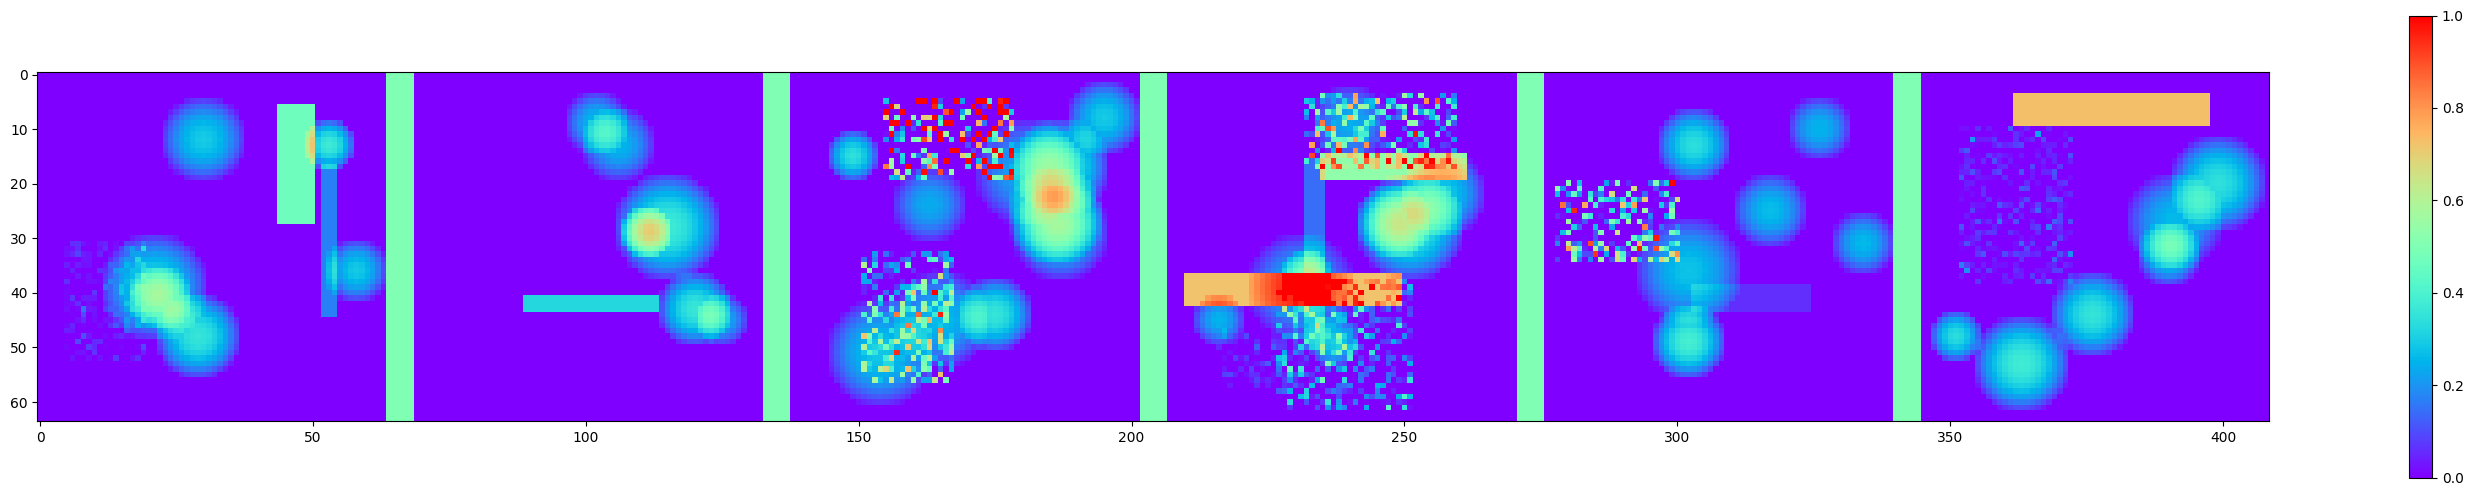

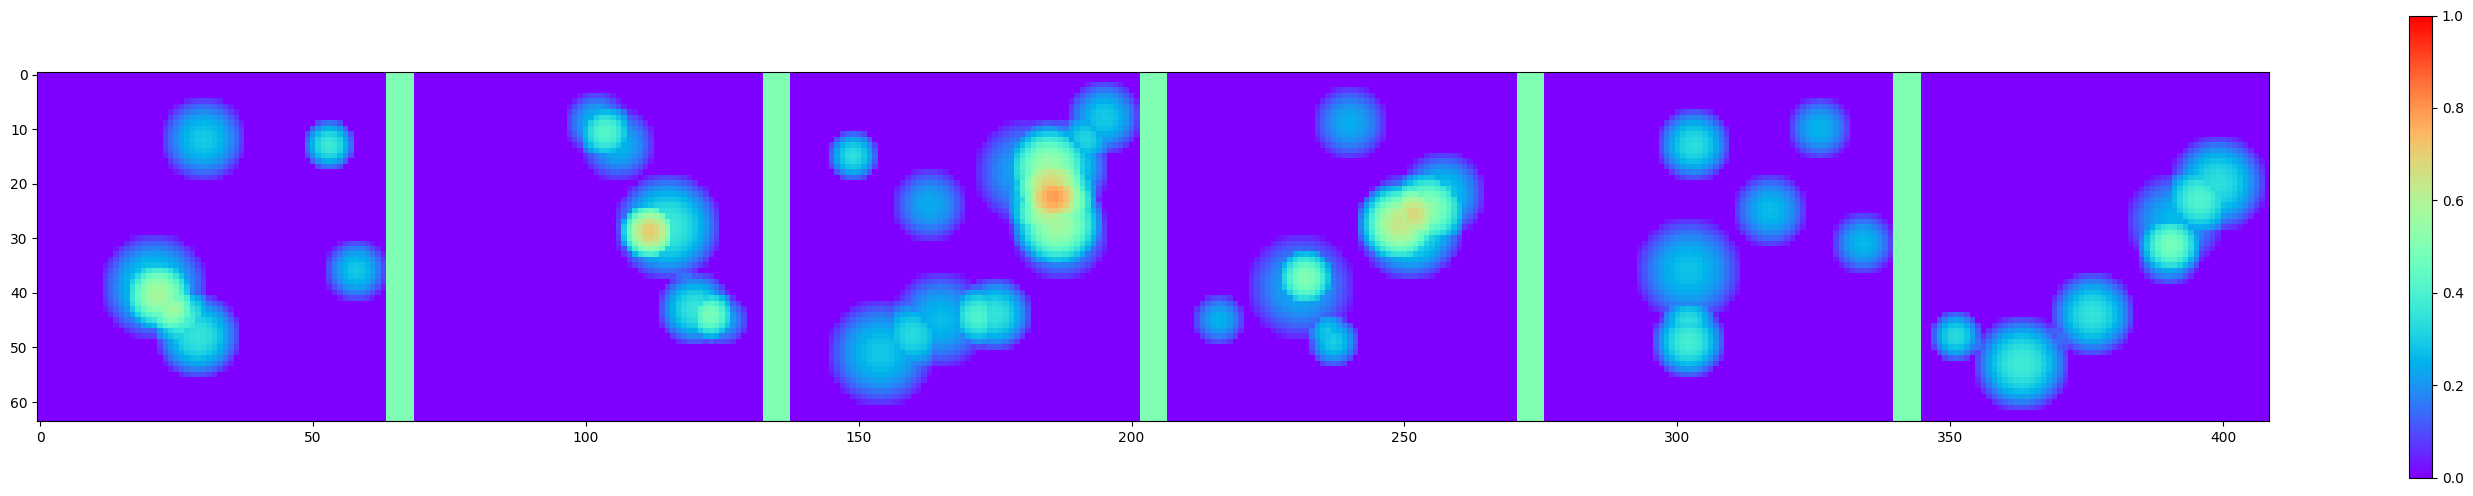

In [7]:
input, target = gen(6)

# Noisy versions (filled and noisy rectangles)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0, max_scale=1)

# Clean versions (only cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0, max_scale=1)

The task is to remove the rectangles (filled or not) from the image. It is a well-posed but a priori challenging problem: spatial context is necessary to achieve it. To address this, we will use another popular FCN: a simplified [U-Net](https://arxiv.org/abs/1505.04597) (see utile.py).

In [8]:
ch_in = 1
ch_out = 1
size = 16

fcn = UNet(ch_in, ch_out, size).to(device)  # 1 input channel, 1 output channel, network size parameter: 16

**Q1:** How many convolution layers does this U-Net contain? How many weights in total when $size = 16$?

In [12]:
print(fcn)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): Down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

**Q2:** For an input image with spatial dimensions $64\times 64$, what is the dimension of the intermediate feature map?

**Q3:** How is the multi-scale processing ensured? What is the purpose of "skip-connections"?

**Q4:** Define a simple training procedure (no validation) using Mean Square Error (MSE) as the cost function and Adam as the optimization method (learning rate of 0.001). Once the training procedure is ready, associate a GPU with the notebook and ensure that the denoising task is well learned.

In [ ]:
def criterion(output, target):
    return ...

In [ ]:
nepochs = 40
nbatches = 100  # Number of batches per epoch
batchsize = 32  # Batch size

train_losses = []  # List to store training losses

fcn = fcn.to(device)

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []  # List to store losses for each batch in the epoch

    for i in range(nbatches):
        # Load inputs
        inputs, targets = gen(batchsize)

        ...

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

In [ ]:
plt.plot(train_losses)

In [ ]:
#visualization:

fcn.eval()

target = make_batch(6, rec=0., noisy_rec=0., disc=0.002).to(device)
noise = make_batch(6, rec=0.0003, noisy_rec=0.0003, disc=0.).to(device)
input = target + noise

# output =

...

# Task
Count the number of `nn.Conv2d` and `nn.ConvTranspose2d` layers in the `UNet` model, and calculate the total number of trainable parameters for an instantiated `UNet` model with `ch_in=1`, `ch_out=1`, and `size=16`.

## Analyze UNet architecture

### Subtask:
Read the `UNet` class definition in `utile.py` to identify all `nn.Conv2d` and `nn.ConvTranspose2d` layers to count them.


**Reasoning**:
To analyze the `UNet` class and count its convolutional layers, I need to first inspect the content of `utile.py` where the class is defined. The `!cat` command is suitable for displaying the file content.



In [9]:
!
cat utile.py

SyntaxError: invalid syntax (ipython-input-1743770761.py, line 2)

**Reasoning**:
The previous command `!\ncat utile.py` resulted in a `SyntaxError` because the `!` magic command was separated from `cat` by a newline. I will correct this by removing the newline to properly execute the shell command `cat utile.py`.



In [10]:
import os
if os.path.exists('utile.py'):
    !cat utile.py
else:
    print('utile.py not found. Please ensure it is in the current directory.')

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Le 19/01/2022
@author: lepetit
#fonctions utiles pour le TP du 21/01
"""

import torch
import numpy as np
from random import randint
import matplotlib.pyplot as plt

#############################################################
#pour la visualisation des images ###########################
#############################################################

def voir_mat(data2, fig, min_scale=-10,max_scale=70):

    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(data2, interpolation='nearest', cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def voir_tens(image, fig, min_scale=-1,max_scale=1):
    im=image[0,0,:,:].numpy()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    plt.imshow(im, interpolation='nearest',  cmap=plt.cm.rainbow) #cmap=plt.cm.ocean)
    plt.clim(min_scale,max_scale)
    plt.colorbar()
    plt.show()

def conc(image1,image2,dim=3

**Reasoning**:
Based on the inspection of `utile.py`, I will now count the `nn.Conv2d` and `nn.ConvTranspose2d` layers and then calculate the total trainable parameters for the `UNet` model with the specified input parameters.



In [11]:
import torch.nn as nn

# Count Conv2d and ConvTranspose2d layers
conv2d_count = 0
convtranspose2d_count = 0

def count_conv_layers(module):
    global conv2d_count, convtranspose2d_count
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            conv2d_count += 1
        elif isinstance(m, nn.ConvTranspose2d):
            convtranspose2d_count += 1

# Instantiate the UNet model using the previously defined 'fcn' variable or creating a new one if 'fcn' is not guaranteed to be the UNet instance
# For clarity and to ensure we're using the correct UNet for the parameter count, let's re-instantiate it.
# Assuming UNet class is available after the 'cat utile.py' output.

# Note: The UNet model is already defined in the context, so we can use that.
# fcn = UNet(ch_in, ch_out, size).to(device)
# The global variables ch_in=1, ch_out=1, size=16 are available from the kernel state.

# Create a new UNet instance to ensure we are counting for the specified parameters (ch_in=1, ch_out=1, size=16)
model_for_counting = UNet(ch_in, ch_out, size)

# Count layers in the instantiated model
count_conv_layers(model_for_counting)

print(f"Number of nn.Conv2d layers: {conv2d_count}")
print(f"Number of nn.ConvTranspose2d layers: {convtranspose2d_count}")

# Calculate total trainable parameters
total_params = sum(p.numel() for p in model_for_counting.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Number of nn.Conv2d layers: 20
Number of nn.ConvTranspose2d layers: 4
Total number of trainable parameters: 926786


## Summary:

### Q&A
*   The `UNet` model has 20 `nn.Conv2d` layers and 4 `nn.ConvTranspose2d` layers.
*   The total number of trainable parameters for an instantiated `UNet` model with `ch_in=1`, `ch_out=1`, and `size=16` is 926,786.

### Data Analysis Key Findings
*   The `UNet` architecture, when instantiated with `ch_in=1`, `ch_out=1`, and `size=16`, contains 20 `nn.Conv2d` layers.
*   This specific `UNet` configuration also includes 4 `nn.ConvTranspose2d` layers.
*   The total number of trainable parameters for this `UNet` model is 926,786.

### Insights or Next Steps
*   The parameter count of 926,786 indicates a moderately sized model, which might be suitable for tasks with limited computational resources or smaller datasets.
